## Baseline Model and Improved Versions

This notebook explores important features with Decision Tree and uses LogReg as a baseline model.
The baseline then gets improved by limiting features, using GridSearchCV, scaling and SMOTE.

In [1]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, precision_score, log_loss, recall_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE


# Manual Train test split -- splits session ID in .70 of the session for train and .3 of the session for test.
#Returns a train dataframe and a test
from src.train_test_split_df import *

In [2]:
df = pd.read_csv('data/tracks_session_clean.csv', index_col=0)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167880 entries, 0 to 167879
Data columns (total 48 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   session_id                       167880 non-null  object 
 1   session_position                 167880 non-null  int64  
 2   session_length                   167880 non-null  int64  
 3   date                             167880 non-null  object 
 4   EarlyAM                          167880 non-null  int64  
 5   Evening                          167880 non-null  int64  
 6   LateAMEarlyPM                    167880 non-null  int64  
 7   LatePM                           167880 non-null  int64  
 8   Night                            167880 non-null  int64  
 9   track_id                         167880 non-null  object 
 10  skipped                          167880 non-null  int64  
 11  hist_seekfwd                     167880 non-null  int64  
 12  hi

In [4]:
drop_col = ['session_id', 'session_length', 'date', 'track_id', 'hist_user_behavior_reason_start', 'beat_strength', 'dyn_range_mean']
def drop(df):
    df = df.drop(labels=drop_col, axis=1)
    return df

### Decision Tree

In [5]:
Train, test = train_test_split_df(df)

In [6]:
Train = drop(Train)
Test = drop(test)

In [7]:
Train['skipped'].value_counts(normalize=True)

1    0.527374
0    0.472626
Name: skipped, dtype: float64

In [8]:
X_train = Train.drop('skipped', axis=1)
X_test = Test.drop('skipped', axis=1)
y_train = Train['skipped']
y_test = Test['skipped']

In [9]:
dt = DecisionTreeClassifier()

In [10]:
param_grid = {'max_depth': range(2, 11),
             'min_samples_split': range(2,5)
             }
gs = GridSearchCV(dt, param_grid)
gs.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 11),
                         'min_samples_split': range(2, 5)})

In [11]:
gs.best_params_

{'max_depth': 7, 'min_samples_split': 4}

In [12]:
dt = DecisionTreeClassifier(max_depth=8)

In [13]:
dt.fit(X_train, y_train)
dt.score(X_test, y_test)

0.5373178641574933

In [14]:
features=X_train.columns.tolist()
important = dt.feature_importances_
important_features = pd.DataFrame(important, index=features, columns=['Important'])
important_features.sort_values('Important', ascending=False).head(15)

,Important
pause_before_play,0.271155
catalog,0.080014
hist_seekback,0.061566
session_position,0.061400
hist_shuffle,0.056027
premium,0.044915
hist_seekfwd,0.035307
radio,0.033620
duration,0.032582
acoustic_vector_0,0.032325


In [15]:
preds= dt.predict(X_test)

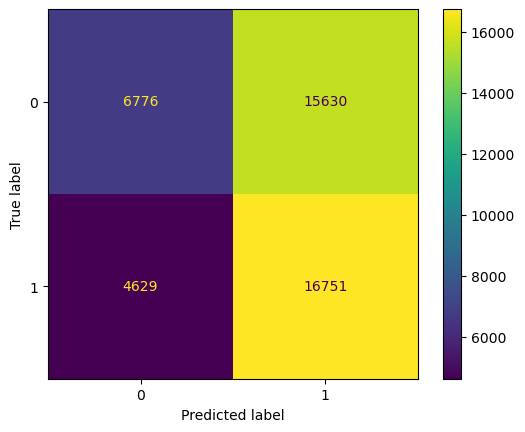

In [16]:
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(cm).plot()

In [17]:
precision_score(y_test, preds)

0.5173095333683333

Important features causing skips:

- pause_before_play	
- catalog	
- hist_seekback	
- radio	
- editorial_playlist
- hist_shuffle
- hist_seekfwd
- session_position

# Logistic Regression

In [18]:
Train, test = train_test_split_df(df)

In [19]:
Train = drop(Train)
Test = drop(test)

In [20]:
X_train = Train['pause_before_play'].array.reshape(-1, 1)
X_test = Test['pause_before_play'].array.reshape(-1, 1)
y_train = Train['skipped']
y_test = Test['skipped']

In [21]:
logreg = LogisticRegression()

In [22]:
param_grid = {'penalty': ['l2'],
             'C': [.1, 10, 100, 1000, 10000],
              'solver': ['liblinear', 'newton-cg'],
             }
gs = GridSearchCV(logreg, param_grid)

In [23]:
gs.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(),
             param_grid={'C': [0.1, 10, 100, 1000, 10000], 'penalty': ['l2'],
                         'solver': ['liblinear', 'newton-cg']})

In [24]:
gs.best_params_

{'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}

In [25]:
logreg = LogisticRegression(penalty='l2', C=.1, solver='liblinear')

In [26]:
logreg.fit(X_train, y_train)

LogisticRegression(C=0.1, solver='liblinear')

In [27]:
logreg.score(X_test, y_test)

0.516991732517243

In [28]:
coef = logreg.coef_

In [29]:
odds = np.exp(coef)
odds.astype(float)

array([[1.7620207]])

If there is a pause before playing, that improves the chance of skipping by 1.76 times. 

# Logistic Regression version 2

In [30]:
#Train, test = train_test_split_df(df)

In [31]:
#Train = drop(Train)
#Test = drop(test)

In [32]:
#X_train = Train[['pause_before_play', 'session_position', 'catalog', 'hist_shuffle', 'premium']]
#X_test = Test[['pause_before_play', 'session_position', 'catalog', 'hist_shuffle', 'premium']]
#y_train = Train['skipped']
#y_test = Test['skipped']

In [33]:
df = drop(df)

In [34]:
X = df[['pause_before_play', 'session_position', 'catalog', 'hist_shuffle', 'premium']]
y = df['skipped']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [35]:
scaled_pipeline = Pipeline([('smote', SMOTE(random_state=42)),
                            ('scaler', StandardScaler()), 
                            ('logreg', LogisticRegression(random_state=42))])

In [36]:
scaled_pipeline.fit(X_train, y_train)

scaled_pipeline.score(X_test, y_test)

0.5614486538003336

In [37]:
grid = [{'logreg__C': [0.1, 1, 10, 100, 1000, 10000], 
         'logreg__solver': ['liblinear', 'newton-cg', 'lbfgs'], 
         'logreg__penalty': ['l2']}]

In [38]:
gridsearch = GridSearchCV(estimator=scaled_pipeline, 
                          param_grid=grid, 
                          scoring='recall', 
                          cv=3)

In [39]:
gridsearch.fit(X_train, y_train)

gridsearch.score(X_test, y_test)

0.6749965610527764

In [40]:
gridsearch.best_estimator_

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('logreg',
                 LogisticRegression(C=0.1, random_state=42,
                                    solver='liblinear'))])

In [41]:
y_pred = gridsearch.predict(X_test)

In [42]:
recall_score(y_test, y_pred)

0.6749965610527764

In [ ]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()

# Gradient Boosting Classifier

In [49]:
X = df[['pause_before_play', 'session_position', 'catalog', 'hist_shuffle', 'premium']]
y = df['skipped']

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [50]:
scaled_pipeline = Pipeline([('smote', SMOTE(random_state=42)),
                            ('scaler', StandardScaler()), 
                            ('boost', GradientBoostingClassifier(random_state=42))])

In [51]:
scaled_pipeline.fit(X_train, y_train)

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('boost', GradientBoostingClassifier(random_state=42))])

In [52]:
grid = [{'boost__max_depth': [2, 3, 4, 5, 6], 
         'boost__learning_rate': [.01, .1, 1]}]

In [53]:
gridsearch = GridSearchCV(estimator=scaled_pipeline, 
                          param_grid=grid, 
                          scoring='recall', 
                          cv=3)

In [54]:
gridsearch.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=42)),
                                       ('scaler', StandardScaler()),
                                       ('boost',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid=[{'boost__learning_rate': [0.01, 0.1, 1],
                          'boost__max_depth': [2, 3, 4, 5, 6]}],
             scoring='recall')

In [55]:
gridsearch.best_estimator_

Pipeline(steps=[('smote', SMOTE(random_state=42)), ('scaler', StandardScaler()),
                ('boost',
                 GradientBoostingClassifier(learning_rate=0.01, max_depth=5,
                                            random_state=42))])

In [56]:
gridsearch.score(X_test, y_test)

0.6700575994054255